## The Pacific region named Niño 3.4 (5N-5S, 170W-120W) is used to define the Sea Surface Temperatures (SST) anomalies that defines a el Niño event. Moreover, the Oceanic Niño Index (ONI) is calculated based on the data of this region.  

## Taking this information into account, in this analysis we are going to select those observations and cluster them using DBSCAN. We store this values in a new .csv called ONI region



### Import libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf
cf.go_offline()

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


### Check the data

In [49]:
data = pd.read_csv('../Data/enso_data_cleaned.csv')
data['date'] = pd.to_datetime(data['date'])
data.head()

,obs,year,month,day,date,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.
0,1,1980,3,7,1980-03-07,-0.02,-109.46,-6.8,0.7,NaN,26.14,26.24
1,2,1980,3,8,1980-03-08,-0.02,-109.46,-4.9,1.1,NaN,25.66,25.97
2,3,1980,3,9,1980-03-09,-0.02,-109.46,-4.5,2.2,NaN,25.69,25.28
3,4,1980,3,10,1980-03-10,-0.02,-109.46,-3.8,1.9,NaN,25.57,24.31
4,5,1980,3,11,1980-03-11,-0.02,-109.46,-4.2,1.5,NaN,25.30,23.19


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178080 entries, 0 to 178079
Data columns (total 12 columns):
obs          178080 non-null int64
year         178080 non-null int64
month        178080 non-null int64
day          178080 non-null int64
date         178080 non-null datetime64[ns]
latitude     178080 non-null float64
longitude    178080 non-null float64
zon.winds    152917 non-null float64
mer.winds    152918 non-null float64
humidity     112319 non-null float64
air temp.    159843 non-null float64
s.s.temp.    161073 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(4)
memory usage: 16.3 MB


### We plot the observations that are contain in the interest region (5N-5S, 170W-120W). We increase 0.5 the latitude for each side to include all observations that are set at around 5. 

In [50]:
oni_region = data[(data['latitude'] < 5.5) & (data['latitude'] > -5.5) & (data['longitude'] > -170) & (data['longitude'] < -120)]
oni_region.shape

(50608, 12)

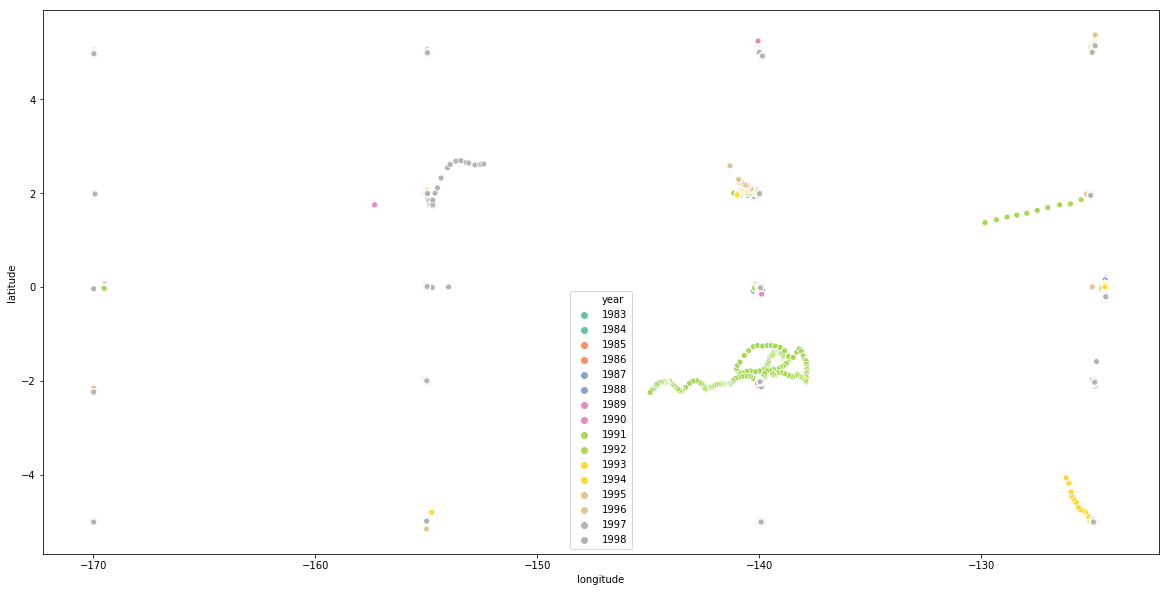

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(x=oni_region['longitude'], y=oni_region['latitude'], hue=oni_region['year'],legend= 'full', palette='Set2' )

### We use DBSCAN method from sklearn to cluster our observations. Each cluster will correspond to one different buoy.

#### We will cluster the observations in base of their location and year. Thus, we define X with the longitude and latitude.

In [8]:
X = oni_region[['latitude', 'longitude']]

#### We set the most important parameters for DBSCAN

In [75]:
eps = 1.2
# The maximum distance between two samples for them to be considered as in the same neighborhood.

min_samples = 15
# The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

n_jobs = -1
# The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.

#### We initialize and fit the model

In [76]:
dbs = DBSCAN(eps = eps, min_samples= min_samples, n_jobs= n_jobs)
dbs.fit(X)

DBSCAN(algorithm='auto', eps=1.2, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=15, n_jobs=-1, p=None)

#### We evaluate the model using the Silhouette score.

In [77]:
# A silhouette score ranges from -1 to 1, with -1 being the worst score possible and 1 being the best score. Silhouette scores of 0 suggest overlapping clusters.
silhouette_score(X, dbs.labels_, sample_size= 50000)

0.8957757516998994

#### We add the labels from DBSCAN to a new column in the dataset.

In [78]:
oni_region['buoy_label'] = dbs.labels_

In [79]:
len(oni_region['buoy_label'].unique())

21

In [80]:
oni_region['buoy_label'].value_counts().tail()

 3     1257
 19     998
 8      441
 11      23
-1        8
Name: buoy_label, dtype: int64

In [81]:
oni_region['buoy_label'].value_counts().head()

1     8742
0     4483
5     3656
13    3308
17    2791
Name: buoy_label, dtype: int64

#### We plot the coordinates together with the label.

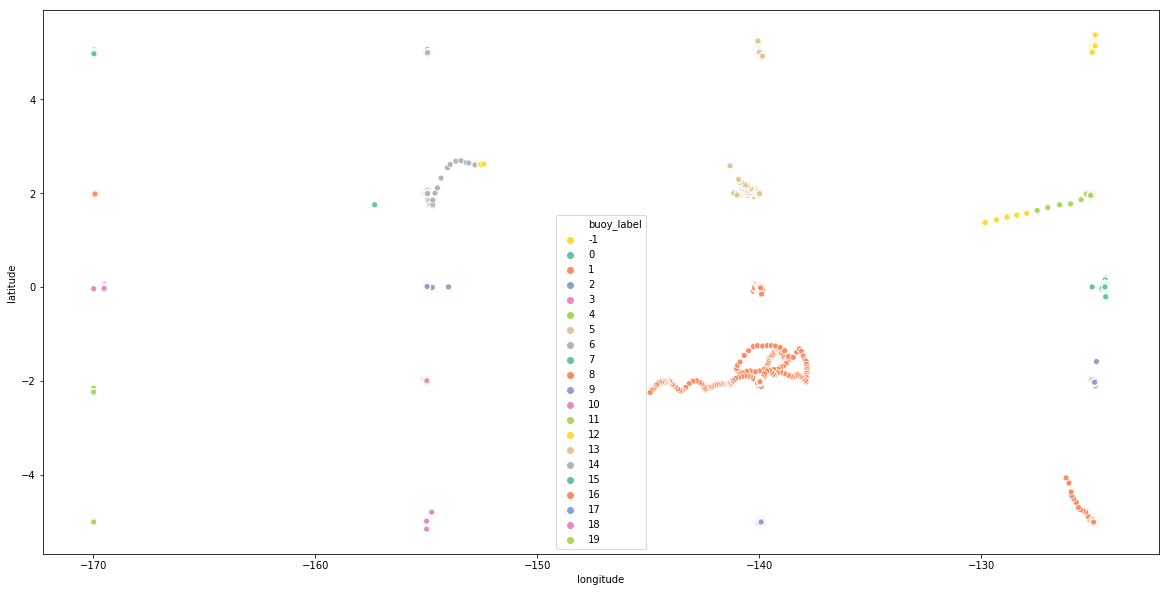

In [82]:
location = oni_region[['latitude', 'longitude', 'buoy_label']]

x = location['longitude']
y = location['latitude']
hue = location['buoy_label']


###plot

fig, ax = plt.subplots(figsize=(20, 10))

# Label to each color
color_labels = hue.unique()

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color = dict(zip(color_labels, rgb_values))


sns.scatterplot(x, y,  hue = hue, palette = color, legend= 'full')

### Similarly as with all the points, I cannot fit any parameter combination in the DBSCAN so all groups are well defined. The reason for this is that the shapes of the groups are very different plus there are so many groups to classify. 

#### In order to perform a perfect group clustering I should divide the data into groups and run the analysis for each group. However, as it is not the main focus of my project, I'll leave it.

#### The options that we have to cluster them all are:
- Divide & Cluster tactic.
- Try another unsupervised method for clustering.
- Take into account more dimensions.

#### However, as I don't have more time for analysis, I limit to save the cluster of the observation inside the ONI region. 

### We save our results in a .csv

In [138]:
oni_region.to_csv('../Data/Oni_region_label.csv', index= False)